In [159]:
!pip install mat73
# !pip install git+https://github.com/nickkunz/smogn.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [160]:
# import smogn
import random as rn
from scipy.io import loadmat
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
import numpy as np
import mat73
from numpy.random import seed
import os

seed = 40
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [161]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/Git/WIP_NoteBooks
%cd /content/gdrive/MyDrive/Colab Notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks


In [162]:
data_features = mat73.loadmat('X_train_python_features_collection.mat')
data_features.keys()

dict_keys(['X_train_python_features_collection'])

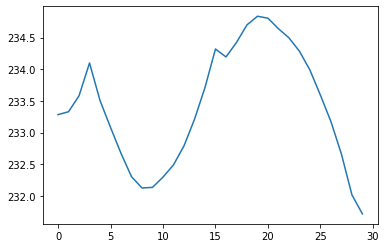

In [163]:
X_features = data_features['X_train_python_features_collection']
plt.plot(X_features[5,2,:,1])
plt.show()

In [164]:
pore_data = pd.read_csv('In718 Sample Information.csv') 
max_pore_area = pore_data['Max Pore Area'].to_numpy()
y = max_pore_area.reshape(240,1)
y.shape

(240, 1)

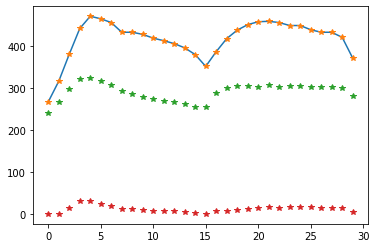

(240, 5, 30, 3)

In [165]:
X_features_trimmed = X_features[:,:,:,[0,1,2]]
plt.plot(X_features[239,2,:,0])
plt.plot(X_features_trimmed[239,2,:],'*')
plt.show()
X_features_trimmed.shape

In [166]:
data_features_4Folds = mat73.loadmat('X_train_python_features_collection_4Folds.mat')
data_features_4Folds.keys()

dict_keys(['X_Q1', 'X_Q2', 'X_Q3', 'X_Q4', 'class', 'y_Q1', 'y_Q2', 'y_Q3', 'y_Q4'])

In [167]:
classes = data_features_4Folds['class']
classes.shape

(240,)

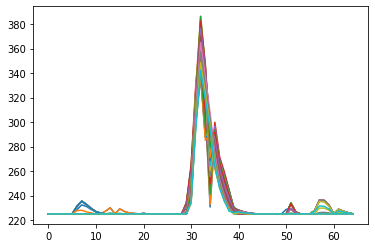

In [168]:
data_profiles = mat73.loadmat('X_train_python_collection.mat')
X_profiles = data_profiles['X_train_python_collection']
plt.plot(X_profiles[5,2,:,:].T)
plt.show()

# Helper Functions

In [169]:
def prediction_results(cnn,X_test,y_test,X_train,y_train):
  test_predictions = cnn.predict(X_test)
  train_predictions = cnn.predict(X_train)

  predictionError = y_test - test_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_test)-np.min(y_test))
  rmse_wrt_mean = rmse/np.mean(y_test)

  print('For Test data--->\nRMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_test)-np.min(y_test),rmse_wrt_range,np.mean(y_test),rmse_wrt_mean))
  
  predictionError = y_train - train_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_train)-np.min(y_train))
  rmse_wrt_mean = rmse/np.mean(y_train)

  print('\nFor Train data--->\nRMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_train)-np.min(y_train),rmse_wrt_range,np.mean(y_train),rmse_wrt_mean))

  data_max = max(np.max(test_predictions), np.max(y_test),np.max(train_predictions), np.max(y_train))
  plt.plot(train_predictions,y_train,'b.')
  plt.plot(test_predictions,y_test,'r.')
  plt.legend(['test','train'])
  plt.plot([0,data_max],[0,data_max])
  plt.show()

def training_history_with_validation(training):
  plt.plot(training.history['loss'])
  plt.plot(training.history['val_loss'])
  plt.ylabel('loss')
  # plt.plot(training.history['root_mean_squared_error'])
  # plt.plot(training.history['val_root_mean_squared_error'])
  # plt.ylabel('root_mean_squared_error')
  plt.xlabel('epoch' )
  plt.legend(['train','dev'])
  plt.show()

def training_history(training):
  plt.plot(training.history['loss'])
  plt.ylabel('loss')
  # plt.plot(training.history['root_mean_squared_error'])
  # plt.ylabel('root_mean_squared_error')
  plt.xlabel('epoch' )
  plt.legend(['train'])
  plt.show()

# def plot_fitting_history(history,filename,dpi):
def plot_fitting_history(history):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  if epochs > 100: plt.xticks(np.arange(0, epochs + 1, step=int(epochs/100)*10))
  else: plt.xticks(np.arange(0, epochs + 1, step=5))
  if 'val_loss' in history.history.keys():
    plt.plot(epoch_data,history.history['val_loss'],'o--')
    plt.legend(['Training','Validation'])
  else:
    plt.legend(['Training'])
  # plt.savefig(filename, dpi=dpi)
  plt.show()

def accuracy_measure(predictions, true_value, percentage):
  scores = []
  for p,t in zip(predictions,true_value):
    if abs(p-t) < t*percentage:
      scores.append(1)
  print('Accuracy: {}% out of {} items'.format(round(sum(scores)/predictions.shape[0]*100,2), predictions.shape[0]))
  return round(sum(scores)/predictions.shape[0],4)

def combined_prediction_results(test_predictions,y_test):
  predictionError = y_test - test_predictions;
  squares = predictionError**2;
  rmse = np.sqrt(np.mean(squares))
  rmse_wrt_range = rmse/(np.max(y_test)-np.min(y_test))
  rmse_wrt_mean = rmse/np.mean(y_test)

  print('RMSE: {}\nRange: {}\nRMSE_wrt_Range: {}\nMean: {}\nRMSE_wrt_Mean: {}'.\
        format(rmse,np.max(y_test)-np.min(y_test),rmse_wrt_range,np.mean(y_test),rmse_wrt_mean))
  
def combined_predictions_4Folds(X,Classifier_model,Q1_model,Q2_model,Q3_model,Q4_model):
  y_test_pred = Classifier_model.predict(X)
  Q1_test_predictions = Q1_model.predict(X)
  Q2_test_predictions = Q2_model.predict(X)
  Q3_test_predictions = Q3_model.predict(X)
  Q4_test_predictions = Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1_test_predictions,Q2_test_predictions,Q3_test_predictions,Q4_test_predictions), axis = 1)
  combined_test_predictions1 = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  combined_test_predictions2 = np.sum(np.multiply(Q_test_predictions,np.round(y_test_pred,0)), axis = 1)

  return combined_test_predictions1, combined_test_predictions2

def combined_predictions_2Folds(X,Classifier_model,Q1Q2_model,Q3Q4_model):
  y_test_pred = Classifier_model.predict(X)
  Q1Q2_test_predictions = Q1Q2_model.predict(X)
  Q3Q4_test_predictions = Q3Q4_model.predict(X)
  Q_test_predictions = np.concatenate((Q1Q2_test_predictions,Q3Q4_test_predictions), axis = 1)
  combined_test_predictions1 = np.sum(np.multiply(Q_test_predictions,y_test_pred), axis = 1)
  combined_test_predictions2 = np.sum(np.multiply(Q_test_predictions,np.round(y_test_pred,0)), axis = 1)

  return combined_test_predictions1, combined_test_predictions2

# k-fold preparation

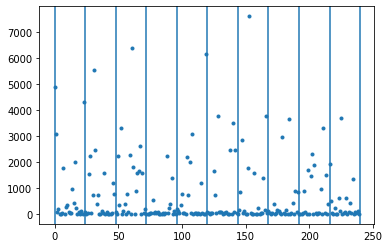

In [170]:
indexes = np.array([  4, 233,  81, 204, 116, 128, 129, 217, 150, 180, 154,  50, 177,
       155,  41,   1, 232, 221, 166, 189,  57,  51, 156,  15,  85, 126,
       178, 206, 212,  94, 239,  30, 234,  42, 218, 121, 161,  99, 197,
        14, 140,  74, 144, 102, 179,  69, 237,  21, 119,  67, 231, 210,
        37, 137,  52, 216, 183, 202, 199,   9, 162,  27, 219, 115, 220,
       223,  34, 227, 113,   7, 171,  63, 185, 136, 158, 132, 141,  19,
       109, 133, 172,  97, 152,  56,  58,  48, 170,  65, 228, 167, 191,
         3, 214,  39, 105,  73, 182,  54, 123, 130,  28, 127,  60,  49,
       236,   0,  20, 148,   8, 111,  78,  53, 138,  79, 143, 207,  35,
       169, 168,  12,  89,  92,  93, 108,  68, 222,  26,  72,  24,  84,
       203,  64, 110,  55,  90,  46,  59, 147,  11, 157,  13,  91, 215,
       103, 131, 175, 225,  10,  71,  66, 114, 101,   5,  16, 192, 142,
       184,  45, 122, 186,  17, 173,  95,  86,  36,  82,  25,  61,  96,
       104,  87, 164, 188,  75, 200, 198,  62,  80, 124, 226, 165, 195,
        18, 112,  40, 153, 118, 213, 159, 201,  47, 229, 107, 181, 135,
        83,   6, 187, 145, 208, 174, 205,   2, 149,  23, 190, 117, 100,
       139, 230, 163,  38,  77, 235, 146,  31, 238, 224, 160, 151,  22,
       176, 134,  33,  43,  29, 194,  76, 106, 211, 120,  70,  32,  98,
       209, 125, 193,  44,  88, 196])
y_shuffled = y[indexes]
plt.plot(y_shuffled,'.')
for i in np.linspace(0,240,11):
  plt.axvline(i)
plt.show()
# indexes

In [171]:
np.arange(0,240,24)

array([  0,  24,  48,  72,  96, 120, 144, 168, 192, 216])

In [172]:
test_indexes_dictionary = {}
counter = 1
for i in np.arange(0,240,24):
  i = int(i)
  key_name = 'test_data_' + str(counter) + '_indexes'
  test_indexes_dictionary.update({key_name: indexes[i:i+24]})
  counter = counter + 1

In [173]:
test_indexes_dictionary.keys()

dict_keys(['test_data_1_indexes', 'test_data_2_indexes', 'test_data_3_indexes', 'test_data_4_indexes', 'test_data_5_indexes', 'test_data_6_indexes', 'test_data_7_indexes', 'test_data_8_indexes', 'test_data_9_indexes', 'test_data_10_indexes'])

In [174]:
test_indexes_dictionary['test_data_1_indexes'], \
test_indexes_dictionary['test_data_2_indexes'], \
test_indexes_dictionary['test_data_3_indexes'],

(array([  4, 233,  81, 204, 116, 128, 129, 217, 150, 180, 154,  50, 177,
        155,  41,   1, 232, 221, 166, 189,  57,  51, 156,  15]),
 array([ 85, 126, 178, 206, 212,  94, 239,  30, 234,  42, 218, 121, 161,
         99, 197,  14, 140,  74, 144, 102, 179,  69, 237,  21]),
 array([119,  67, 231, 210,  37, 137,  52, 216, 183, 202, 199,   9, 162,
         27, 219, 115, 220, 223,  34, 227, 113,   7, 171,  63]))

In [175]:
train_indexes_dictionary = {}
counter = 1
for key in test_indexes_dictionary.keys():
  key_name = 'train_data_' + str(counter) + '_indexes'
  train_indexes = []
  for _, num in enumerate(indexes):
    if num not in test_indexes_dictionary[key]:
      train_indexes.append(num)
  train_indexes = np.array(train_indexes)
  train_indexes_dictionary.update({key_name: train_indexes})
  counter = counter + 1

In [176]:
train_indexes_dictionary.keys()

dict_keys(['train_data_1_indexes', 'train_data_2_indexes', 'train_data_3_indexes', 'train_data_4_indexes', 'train_data_5_indexes', 'train_data_6_indexes', 'train_data_7_indexes', 'train_data_8_indexes', 'train_data_9_indexes', 'train_data_10_indexes'])

In [177]:
train_indexes_dictionary['train_data_2_indexes']

array([  4, 233,  81, 204, 116, 128, 129, 217, 150, 180, 154,  50, 177,
       155,  41,   1, 232, 221, 166, 189,  57,  51, 156,  15, 119,  67,
       231, 210,  37, 137,  52, 216, 183, 202, 199,   9, 162,  27, 219,
       115, 220, 223,  34, 227, 113,   7, 171,  63, 185, 136, 158, 132,
       141,  19, 109, 133, 172,  97, 152,  56,  58,  48, 170,  65, 228,
       167, 191,   3, 214,  39, 105,  73, 182,  54, 123, 130,  28, 127,
        60,  49, 236,   0,  20, 148,   8, 111,  78,  53, 138,  79, 143,
       207,  35, 169, 168,  12,  89,  92,  93, 108,  68, 222,  26,  72,
        24,  84, 203,  64, 110,  55,  90,  46,  59, 147,  11, 157,  13,
        91, 215, 103, 131, 175, 225,  10,  71,  66, 114, 101,   5,  16,
       192, 142, 184,  45, 122, 186,  17, 173,  95,  86,  36,  82,  25,
        61,  96, 104,  87, 164, 188,  75, 200, 198,  62,  80, 124, 226,
       165, 195,  18, 112,  40, 153, 118, 213, 159, 201,  47, 229, 107,
       181, 135,  83,   6, 187, 145, 208, 174, 205,   2, 149,  2

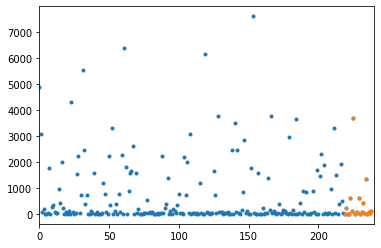

In [178]:
test_indexes = np.arange(0,239)
train = y_shuffled[0:-1]
plt.plot(test_indexes,train,'.')

test_indexes = np.arange(219,239)
train = y_shuffled[-21:-1]
plt.plot(test_indexes,train,'.')

plt.xlim([0,240])
plt.show()

In [179]:
folds = 10
items_per_fold = int(len(y)/folds)

# Functions for different Models

In [241]:
# def get_regression_model(X_train, y_train, num_features):

#   os.environ['PYTHONHASHSEED'] = '0'
#   np.random.seed(0)
#   rn.seed(12345)
#   session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#   from keras import backend as K
#   tf.random.set_seed(1234)
#   sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#   tf.compat.v1.keras.backend.set_session(sess)

#   feature_regression_model = models.Sequential([

#       layers.SeparableConv2D(filters=2**9, kernel_size=2, padding = 'same', activation='relu', input_shape=(5, 30, num_features)),
#       layers.MaxPooling2D(2),
#       layers.BatchNormalization(),
      
#       layers.SeparableConv2D(filters=2**8, kernel_size=2, padding = 'same', activation='relu'),
#       layers.MaxPooling2D((2)),
      
#       layers.SeparableConv2D(filters=2**7, kernel_size=2, padding = 'same', activation='relu'),
#       layers.BatchNormalization(),
          
#       layers.Flatten(),
#       layers.Dense(2**10, activation='relu'),
#       layers.Dense(2**9, activation='relu'),
#       layers.Dense(1, activation='relu')
#   ])

#   learning_rate = 0.0001
#   feature_regression_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
#                 loss='MeanAbsoluteError')

#   early_callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
#   training = feature_regression_model.fit(X_train, y_train, epochs=1000, batch_size=16, shuffle=True, callbacks = early_callbacks, verbose=0)

#   return feature_regression_model, training

def get_classifier_model(X_train, classes_train):

  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(0)
  rn.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  from keras import backend as K
  tf.random.set_seed(1234)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

  classifier_model = models.Sequential([

      layers.SeparableConv2D(filters=2**5, kernel_size=2, padding = 'same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
      layers.MaxPooling2D(2),
      layers.BatchNormalization(),
      
      layers.SeparableConv2D(filters=2**4, kernel_size=2, padding = 'same', activation='relu'),
      layers.MaxPooling2D((2)),
      
      layers.SeparableConv2D(filters=2**3, kernel_size=2, padding = 'same', activation='relu'),
      layers.BatchNormalization(),

      # layers.SeparableConv2D(filters=16, kernel_size=2, padding = 'same', activation='relu', input_shape=(5, 30, 3)),
      # layers.BatchNormalization(),
      # layers.SeparableConv2D(filters=16, kernel_size=2, padding = 'same', activation='relu'),
      # layers.BatchNormalization(),
      # layers.MaxPooling2D(2),
      # layers.Dropout(0.25),
      
      # layers.SeparableConv2D(filters=32, kernel_size=2, padding = 'same', activation='relu'),
      # layers.BatchNormalization(),
      # layers.SeparableConv2D(filters=32, kernel_size=2, padding = 'same', activation='relu'),
      # layers.BatchNormalization(),
      # layers.MaxPooling2D(2),
      # layers.Dropout(0.25),
          
      layers.Flatten(),
      layers.Dense(2**6, activation='relu'),
      # layers.Dropout(0.5),
      layers.Dense(2**5, activation='relu'),
      # layers.Dropout(0.5),
      # layers.Dense(2**6, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
      layers.Dense(int(np.max(classes_train)+1), activation='softmax')
  ])

  learning_rate = 0.0001
  classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                loss='SparseCategoricalCrossentropy',
                metrics=['accuracy'])
  
  # X_train, X_val, classes_train, y_val = train_test_split(X_train, classes_train, test_size=0.2,
  #                                                   random_state=42, stratify=classes_train)
  # early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  # classifier_training = classifier_model.fit(X_train, classes_train, epochs=500, batch_size=32, shuffle=True,
  #           validation_data=(X_val, y_val), callbacks = early_callbacks, verbose=0)
  
  early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  classifier_training = classifier_model.fit(X_train, classes_train, epochs=500, batch_size=32, shuffle=True,
            validation_split = 0.2, callbacks = early_callbacks, verbose=0)

  # early_callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=20)
  # classifier_training = classifier_model.fit(X_train, classes_train, epochs=100, batch_size=16, shuffle=True, callbacks = early_callbacks, verbose=0)

  return classifier_model, classifier_training

def get_classificaion_results(classifier_model,X_test,classes_test):
  from sklearn.metrics import confusion_matrix , classification_report
  import numpy as np
  import seaborn as sn

  y_pred = classifier_model.predict(X_test)
  y_pred_classes = [np.argmax(element) for element in y_pred]

  # cm = tf.math.confusion_matrix(labels=classes_test,predictions=y_pred_classes)
  # plt.figure(figsize = (7,5))
  # sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  # plt.xlabel('Predicted');
  # plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(classes_test, y_pred_classes))
  return classification_report(classes_test, y_pred_classes)

# k-fold Validation

In [242]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
for i in range(len(train_indexes_list)):
  print(train_indexes_list[i])

train_data_1_indexes
train_data_2_indexes
train_data_3_indexes
train_data_4_indexes
train_data_5_indexes
train_data_6_indexes
train_data_7_indexes
train_data_8_indexes
train_data_9_indexes
train_data_10_indexes


In [265]:
new_classes = np.ones(classes.shape)*-1
low_threshold = 10
medium_threshold = 80
low_pore_indexes = np.where(y<=low_threshold)[0]
medium_pore_indexes = np.where((y>low_threshold) & (y<=medium_threshold))[0]
large_pore_indexes = np.where(y>medium_threshold)[0]
new_classes[low_pore_indexes] = 0
new_classes[medium_pore_indexes] = 1
new_classes[large_pore_indexes] = 2

In [266]:
np.where(y<=low_threshold)[0].shape, np.where((y>low_threshold) & \
        (y<=medium_threshold))[0].shape, np.where(y>medium_threshold)[0].shape

((39,), (94,), (107,))

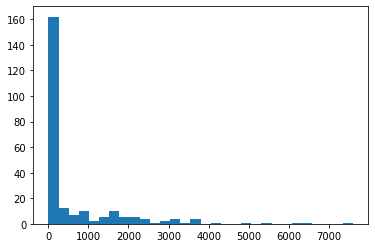

In [267]:
plt.hist(y, bins=30)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

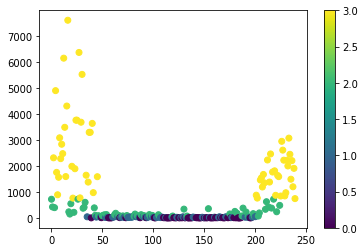

In [268]:
plt.scatter(range(y.shape[0]),y,c=classes)
plt.colorbar()
plt.show

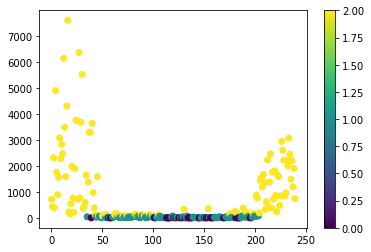

In [269]:
plt.scatter(range(y.shape[0]),y,c=new_classes)
plt.colorbar()

In [270]:
def classification_results(string):
  list_of_strings = string.split(" ")
  filtered_string = []
  for i in list_of_strings:
    if i == '': continue
    else: 
      try:
        filtered_string.append(float(i))
      except:
        continue
  classwise_results = np.array(filtered_string[0:15]).reshape(3,5)
  f1score =  filtered_string[19]
  return classwise_results, f1score

# Classification Model: Thermal Feature based


Round: 1


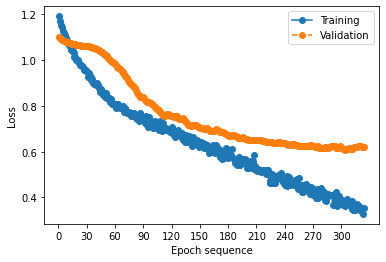

Testing Results
1/1 [==============================] - 0s 114ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.67      0.50      0.57         4
         1.0       0.56      0.71      0.63         7
         2.0       0.83      0.77      0.80        13

    accuracy                           0.71        24
   macro avg       0.69      0.66      0.67        24
weighted avg       0.72      0.71      0.71        24





Round: 2


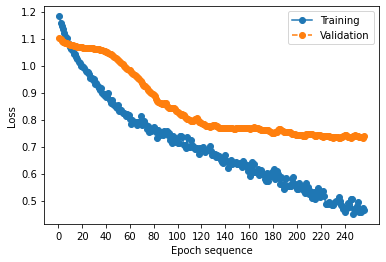

Testing Results
1/1 [==============================] - 0s 103ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.56      0.50      0.53        10
         2.0       0.77      0.83      0.80        12

    accuracy                           0.62        24
   macro avg       0.44      0.44      0.44        24
weighted avg       0.62      0.62      0.62        24





Round: 3


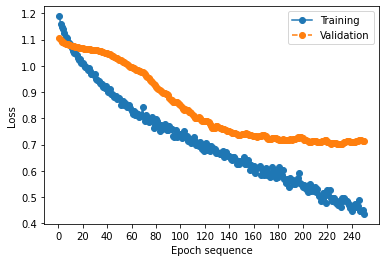

Testing Results
1/1 [==============================] - 0s 115ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.44      0.80      0.57         5
         2.0       0.87      0.87      0.87        15

    accuracy                           0.71        24
   macro avg       0.44      0.56      0.48        24
weighted avg       0.63      0.71      0.66        24





Round: 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

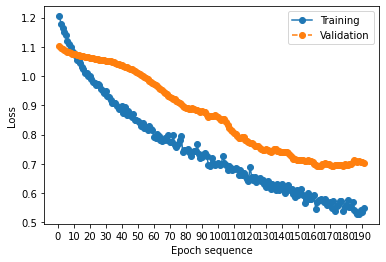

Testing Results
1/1 [==============================] - 0s 173ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.50      0.12      0.20         8
         1.0       0.62      0.80      0.70        10
         2.0       0.56      0.83      0.67         6

    accuracy                           0.58        24
   macro avg       0.56      0.59      0.52        24
weighted avg       0.56      0.58      0.52        24





Round: 5


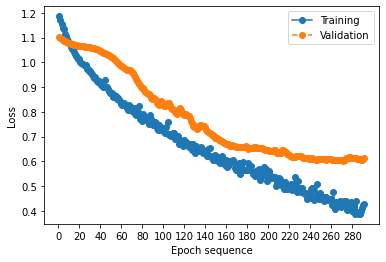

Testing Results
1/1 [==============================] - 0s 145ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.73      0.67      0.70        12
         2.0       0.67      0.80      0.73        10

    accuracy                           0.67        24
   macro avg       0.46      0.49      0.47        24
weighted avg       0.64      0.67      0.65        24





Round: 6


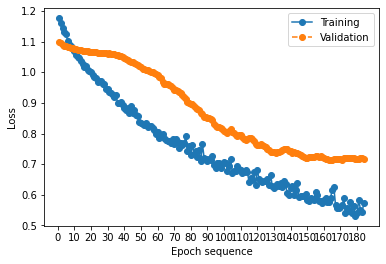

Testing Results
1/1 [==============================] - 0s 115ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.62      0.67      0.64        12
         2.0       0.56      0.50      0.53        10

    accuracy                           0.54        24
   macro avg       0.39      0.39      0.39        24
weighted avg       0.54      0.54      0.54        24





Round: 7


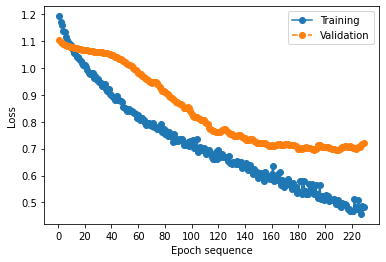

Testing Results
1/1 [==============================] - 0s 176ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.46      0.75      0.57         8
         2.0       0.80      0.73      0.76        11

    accuracy                           0.58        24
   macro avg       0.42      0.49      0.44        24
weighted avg       0.52      0.58      0.54        24





Round: 8


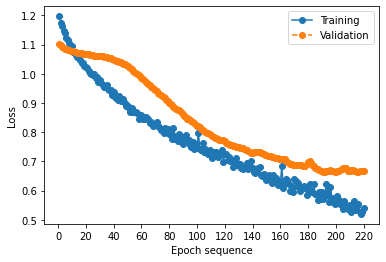

Testing Results
1/1 [==============================] - 0s 109ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.64      0.64      0.64        11
         2.0       0.80      0.80      0.80        10

    accuracy                           0.62        24
   macro avg       0.48      0.48      0.48        24
weighted avg       0.62      0.62      0.63        24





Round: 9


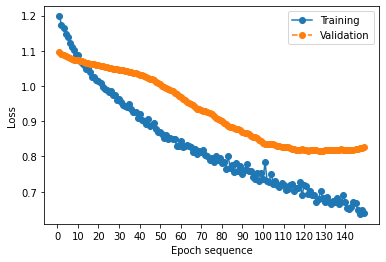

Testing Results
1/1 [==============================] - 0s 105ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      0.70      0.64        10
         2.0       0.75      1.00      0.86         9

    accuracy                           0.67        24
   macro avg       0.44      0.57      0.50        24
weighted avg       0.52      0.67      0.59        24





Round: 10


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

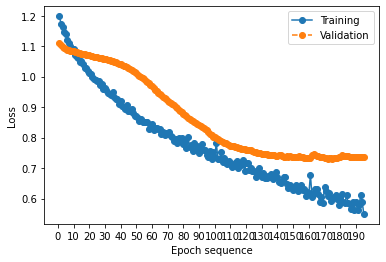

Testing Results
1/1 [==============================] - 0s 101ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.54      0.78      0.64         9
         2.0       0.82      0.82      0.82        11

    accuracy                           0.67        24
   macro avg       0.45      0.53      0.48        24
weighted avg       0.58      0.67      0.61        24






/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [271]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
test_f1score_list_TF = []
train_f1score_list = []
train_stacked_array = np.zeros((0, 5))
test_stacked_array = np.zeros((0, 5))

for i in range(len(train_indexes_list)):

  print('\nRound:',str(i+1))
  X_train = X_features_trimmed[train_indexes_dictionary[train_indexes_list[i]]]
  y_train = y[train_indexes_dictionary[train_indexes_list[i]]]
  # classes_train = classes[train_indexes_dictionary[train_indexes_list[i]]]
  classes_train = new_classes[train_indexes_dictionary[train_indexes_list[i]]]

  X_test = X_features_trimmed[test_indexes_dictionary[test_indexes_list[i]]]
  y_test = y[test_indexes_dictionary[test_indexes_list[i]]]
  # classes_test = classes[test_indexes_dictionary[test_indexes_list[i]]]
  classes_test = new_classes[test_indexes_dictionary[test_indexes_list[i]]]

  classifier_model, classifier_training = get_classifier_model(X_train, classes_train)
  plt.figure()
  plot_fitting_history(classifier_training)

  # print('Training Results\n=================')
  # train_classification_results = get_classificaion_results(classifier_model,X_train,classes_train)
  # train_classwise_results, train_f1score = classification_results(train_classification_results)
  # train_stacked_array = np.vstack((train_stacked_array,train_classwise_results))
  # train_f1score_list.append(train_f1score)

  print('Testing Results\n=================')
  test_classification_results = get_classificaion_results(classifier_model,X_test,classes_test)
  test_classwise_results, test_f1score = classification_results(test_classification_results)
  test_stacked_array = np.vstack((test_stacked_array,test_classwise_results))
  test_f1score_list_TF.append(test_f1score)
  print('\n\n')

In [272]:
df_test_results = pd.DataFrame(test_stacked_array, columns=['class','precision','recall','f1-score','support'])

stacked_items = np.zeros((0, 1))  # Initialize an empty array with 0 rows and n_cols columns
for i in range(10):
    stacked_items = np.vstack((stacked_items, i+1, i+1, i+1))

df_test_results["fold #"] = stacked_items
df_test_results

,class,precision,recall,f1-score,support,fold #
0,0.0,0.67,0.50,0.57,4.0,1.0
1,1.0,0.56,0.71,0.63,7.0,1.0
2,2.0,0.83,0.77,0.80,13.0,1.0
3,0.0,0.00,0.00,0.00,2.0,2.0
4,1.0,0.56,0.50,0.53,10.0,2.0
5,2.0,0.77,0.83,0.80,12.0,2.0
6,0.0,0.00,0.00,0.00,4.0,3.0
7,1.0,0.44,0.80,0.57,5.0,3.0
8,2.0,0.87,0.87,0.87,15.0,3.0
9,0.0,0.50,0.12,0.20,8.0,4.0


In [273]:
df_test_results.to_csv('Thermal feature based results [10-80] thresholds.csv', index=False)

In [274]:
df_TF = pd.read_csv('Thermal feature based results [10-80] thresholds.csv')

In [275]:
df = df_TF[df_TF['class']==0]
df['f1-score'].mean()

0.077

In [276]:
df = df_TF[df_TF['class']==1]
df['f1-score'].mean()

0.626

In [277]:
df = df_TF[df_TF['class']==2]
df['f1-score'].mean()

0.7640000000000001

Average f1 score: 0.487


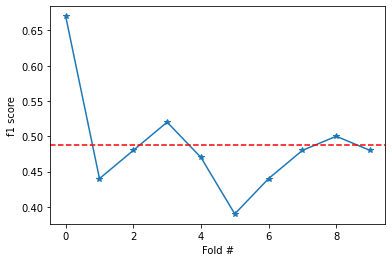

In [278]:
avg_f1score = sum(test_f1score_list_TF)/len(test_f1score_list_TF)
print(f'Average f1 score: {round(avg_f1score,4)}')
plt.plot(test_f1score_list_TF,'*-')
plt.axhline(avg_f1score,color='red', linestyle='--')
plt.xlabel('Fold #')
plt.ylabel('f1 score')
plt.show()

# Classification Model: Thermal History based


Round: 1


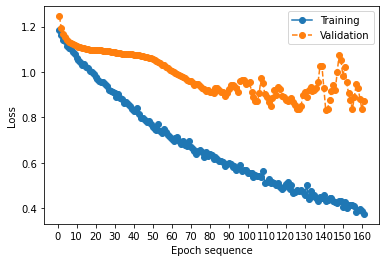

Testing Results
1/1 [==============================] - 0s 181ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.43      0.43      0.43         7
         2.0       0.69      0.85      0.76        13

    accuracy                           0.58        24
   macro avg       0.37      0.42      0.40        24
weighted avg       0.50      0.58      0.54        24





Round: 2


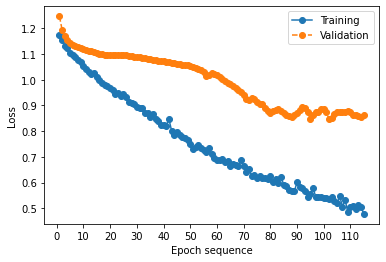

Testing Results
1/1 [==============================] - 0s 178ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.33      0.10      0.15        10
         2.0       0.60      0.75      0.67        12

    accuracy                           0.42        24
   macro avg       0.31      0.28      0.27        24
weighted avg       0.44      0.42      0.40        24





Round: 3


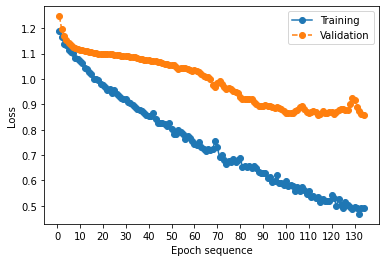

Testing Results
1/1 [==============================] - 0s 106ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.33      1.00      0.50         5
         2.0       1.00      0.60      0.75        15

    accuracy                           0.58        24
   macro avg       0.44      0.53      0.42        24
weighted avg       0.69      0.58      0.57        24





Round: 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

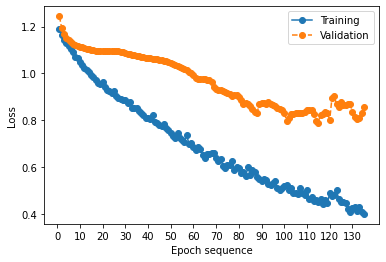

Testing Results
1/1 [==============================] - 0s 102ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0.56      0.50      0.53        10
         2.0       0.36      0.83      0.50         6

    accuracy                           0.46        24
   macro avg       0.64      0.49      0.42        24
weighted avg       0.65      0.46      0.42        24





Round: 5


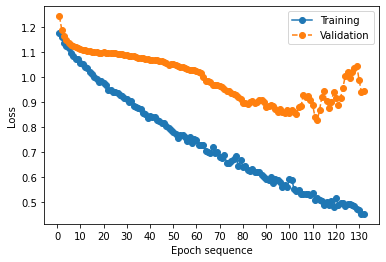

Testing Results
1/1 [==============================] - 0s 102ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.67      0.17      0.27        12
         2.0       0.45      0.90      0.60        10

    accuracy                           0.46        24
   macro avg       0.37      0.36      0.29        24
weighted avg       0.52      0.46      0.38        24





Round: 6


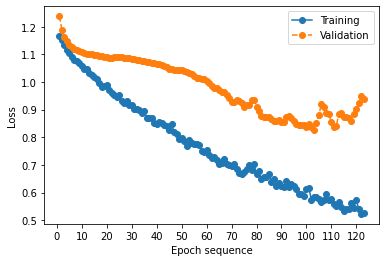

Testing Results
1/1 [==============================] - 0s 104ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.67      0.67      0.67        12
         2.0       0.58      0.70      0.64        10

    accuracy                           0.62        24
   macro avg       0.42      0.46      0.43        24
weighted avg       0.58      0.62      0.60        24





Round: 7


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

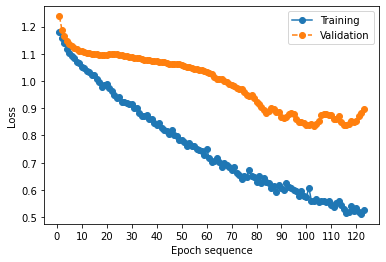

Testing Results
1/1 [==============================] - 0s 124ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.50      0.20      0.29         5
         1.0       0.64      0.88      0.74         8
         2.0       0.82      0.82      0.82        11

    accuracy                           0.71        24
   macro avg       0.65      0.63      0.61        24
weighted avg       0.69      0.71      0.68        24





Round: 8


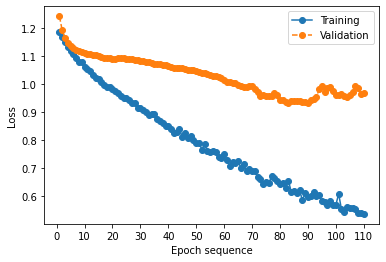

Testing Results
1/1 [==============================] - 0s 113ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         3
         1.0       0.83      0.45      0.59        11
         2.0       0.58      0.70      0.64        10

    accuracy                           0.62        24
   macro avg       0.64      0.72      0.63        24
weighted avg       0.69      0.62      0.62        24





Round: 9


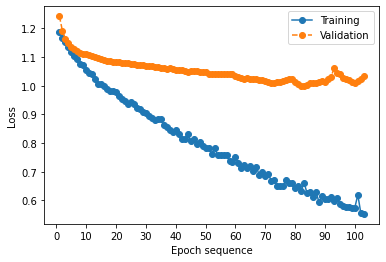

Testing Results
1/1 [==============================] - 0s 165ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.50      0.20      0.29         5
         1.0       0.71      0.50      0.59        10
         2.0       0.60      1.00      0.75         9

    accuracy                           0.62        24
   macro avg       0.60      0.57      0.54        24
weighted avg       0.63      0.62      0.59        24





Round: 10


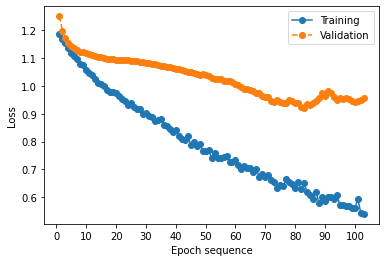

Testing Results
1/1 [==============================] - 0s 155ms/step
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.50      0.22      0.31         9
         2.0       0.44      0.64      0.52        11

    accuracy                           0.38        24
   macro avg       0.31      0.29      0.28        24
weighted avg       0.39      0.38      0.35        24






In [279]:
train_indexes_list = list(train_indexes_dictionary.keys())
test_indexes_list = list(test_indexes_dictionary.keys())
test_f1score_list_TH = []
train_f1score_list = []
train_stacked_array = np.zeros((0, 5))
test_stacked_array = np.zeros((0, 5))

for i in range(len(train_indexes_list)):

  print('\nRound:',str(i+1))
  X_train = X_profiles[train_indexes_dictionary[train_indexes_list[i]]]
  y_train = y[train_indexes_dictionary[train_indexes_list[i]]]
  # classes_train = classes[train_indexes_dictionary[train_indexes_list[i]]]
  classes_train = new_classes[train_indexes_dictionary[train_indexes_list[i]]]

  X_test = X_profiles[test_indexes_dictionary[test_indexes_list[i]]]
  y_test = y[test_indexes_dictionary[test_indexes_list[i]]]
  # classes_test = classes[test_indexes_dictionary[test_indexes_list[i]]]
  classes_test = new_classes[test_indexes_dictionary[test_indexes_list[i]]]

  classifier_model, classifier_training = get_classifier_model(X_train, classes_train)
  plt.figure()
  plot_fitting_history(classifier_training)

  # print('Training Results\n=================')
  # train_classification_results = get_classificaion_results(classifier_model,X_train,classes_train)
  # train_classwise_results, train_f1score = classification_results(train_classification_results)
  # train_stacked_array = np.vstack((train_stacked_array,train_classwise_results))
  # train_f1score_list.append(train_f1score)

  print('Testing Results\n=================')
  test_classification_results = get_classificaion_results(classifier_model,X_test,classes_test)
  test_classwise_results, test_f1score = classification_results(test_classification_results)
  test_stacked_array = np.vstack((test_stacked_array,test_classwise_results))
  test_f1score_list_TH.append(test_f1score)
  print('\n\n')

In [280]:
df_test_results_TH = pd.DataFrame(test_stacked_array, columns=['class','precision','recall','f1-score','support'])

stacked_items = np.zeros((0, 1))  # Initialize an empty array with 0 rows and n_cols columns
for i in range(10):
    stacked_items = np.vstack((stacked_items, i+1, i+1, i+1))

df_test_results_TH["fold #"] = stacked_items
df_test_results_TH

,class,precision,recall,f1-score,support,fold #
0,0.0,0.00,0.00,0.00,4.0,1.0
1,1.0,0.43,0.43,0.43,7.0,1.0
2,2.0,0.69,0.85,0.76,13.0,1.0
3,0.0,0.00,0.00,0.00,2.0,2.0
4,1.0,0.33,0.10,0.15,10.0,2.0
5,2.0,0.60,0.75,0.67,12.0,2.0
6,0.0,0.00,0.00,0.00,4.0,3.0
7,1.0,0.33,1.00,0.50,5.0,3.0
8,2.0,1.00,0.60,0.75,15.0,3.0
9,0.0,1.00,0.12,0.22,8.0,4.0


In [281]:
df_test_results_TH.to_csv('Thermal history based results [10-80] thresholds.csv', index=False)

Average f1 score: 0.429


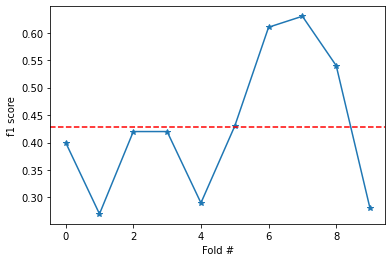

In [282]:
avg_f1score = sum(test_f1score_list_TH)/len(test_f1score_list_TH)
print(f'Average f1 score: {round(avg_f1score,4)}')
plt.plot(test_f1score_list_TH,'*-')
plt.axhline(avg_f1score,color='red', linestyle='--')
plt.xlabel('Fold #')
plt.ylabel('f1 score')
plt.show()

In [283]:
sum(test_f1score_list_TF)/len(test_f1score_list_TF)

0.4870000000000001

In [284]:
# df_TH = pd.read_csv('Thermal history based results [10-80] thresholds.csv')

# Implementation of Paulson (2020) Paper

In [285]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [286]:
# import random
# from deap import creator, base, tools, algorithms

# # Define the problem to be solved
# # X is the input data, y is the output data
# X = X_profiles  # Input data
# y = y  # Output data

# # # Define the evaluation function
# # def evaluate_fitness(individual):
# #     # individual is a list of 0's and 1's representing the selected features
# #     # Convert individual to a list of selected features
# #     selected_features = [i for i, x in enumerate(individual) if x == 1]
# #     # Use selected_features as input for a machine learning model
# #     # and calculate the fitness score based on how well the model performs
# #     # return the fitness score as a tuple
# #     return (fitness_score,)

# def evaluate_fitness(individual):
#     # assume X is a numpy array containing the original feature set
#     selected_features = [i for i, x in enumerate(individual) if x == 1]
#     X_selected = X[:, selected_features]
    
#     # assume y is a numpy array containing the target variable
#     # assume clf is a scikit-learn classifier (e.g., LogisticRegression, RandomForestClassifier, etc.)
#     print(X_selected.shape)
#     classifier_model.fit(X_selected, y)
#     accuracy = classifier_model.score(X_selected, y)
    
#     # maximize accuracy, so negate it to minimize fitness
#     fitness = -accuracy
#     fitness_score = fitness
#     return (fitness_score,)

# # Define the genetic algorithm parameters
# POPULATION_SIZE = 50
# P_CROSSOVER = 0.9
# P_MUTATION = 0.1
# MAX_GENERATIONS = 100
# HALL_OF_FAME_SIZE = 10

# # Define the fitness function and the individual creator
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)

# # Define the toolbox and register the necessary functions
# toolbox = base.Toolbox()
# toolbox.register("attr_bool", random.randint, 0, 1)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X[0]))
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("evaluate", evaluate_fitness)
# toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
# toolbox.register("select", tools.selTournament, tournsize=3)

# # Run the genetic algorithm
# population = toolbox.population(n=POPULATION_SIZE)
# hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
# stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("max", max)

# for generation in range(MAX_GENERATIONS):
#     offspring = algorithms.varAnd(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION)
#     fits = toolbox.map(toolbox.evaluate, offspring)
#     for fit, ind in zip(fits, offspring):
#         ind.fitness.values = fit
#     population = toolbox.select(offspring, k=len(population))
#     hof.update(population)
#     record = stats.compile(population)
#     print("Generation ", generation, ":", record)
    
# # Print the best individual and its fitness score
# best_individual = hof[0]
# print("Best individual: ", best_individual)
# print("Fitness score: ", best_individual.fitness.values[0])